In [1]:
import geopandas as gpd

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [30]:
import os

In [33]:
import json

In [35]:
df = gpd.read_file('../data/SPID_inequality/Data-Table 1.csv')

In [5]:
df2 = gpd.read_file(r'../data/SPID_mpm/Data-Table 1.csv')

In [6]:
data_keys = set(['mean2017', 'poor215','poor365', 'poor685', 'prosgap2017', 'gini', 'theil','lvlvar']+['dep_poor1', 'dep_educ_com', 'dep_educ_enr','dep_infra_elec', 'dep_infra_imps', 'dep_infra_impw2', 'mdpoor_i1'])

In [7]:
def get_distinguishing_keys(this_sub_df):
    return [ key for key in this_sub_df.keys() if 
            (this_sub_df[key].unique().shape[0] > 1)]

In [8]:
def reindex_duplicates_df(this_df):
    index_keys = ['code','geo_code','year','rep_year','lvlvar','data','data_group']
    this_df = this_df.set_index([
        key for key in index_keys if key in this_df.keys()
    ]).sort_index().copy()
    this_df.sort_index()
    
    this_df['child_index'] = 0
    
    for group,data in this_df.groupby(this_df.index):
        if data.shape[0] > 1: 
            add_child_indices(this_df,group,data)
            distinguishing_keys = get_distinguishing_keys(data)
            print(distinguishing_keys)
    

    return this_df#this_df.set_index('child_index',append=True)

def add_child_indices(this_df, group, this_sub_df):
    validate_selection(this_df,group,this_sub_df)
    this_df.loc[group,'child_index'] = np.arange(this_sub_df.shape[0])

def validate_selection(this_df,group,this_sub_df):
    if not np.all(this_df.loc[group] == this_sub_df):
        raise Exception("BAD")

In [36]:
foo = reindex_duplicates_df(df)
bar = reindex_duplicates_df(df2)

In [10]:
print(foo.index.names)
print(bar.index.names)

['code', 'geo_code', 'year', 'rep_year', 'lvlvar', 'data', 'data_group']
['code', 'geo_code', 'year', 'rep_year']


## handle the easier multi-dimensional-poverty data

In [25]:
output_keys = ['year',
               'dep_poor1','dep_educ_com','dep_educ_enr',
               'dep_infra_elec','dep_infra_imps','dep_infra_impw2',
               'mdpoor_i1']

In [34]:
rebar = bar.reset_index().set_index('geo_code')
rebar = rebar.groupby(rebar.index).agg(list)
rebar['code'] = rebar.code.apply(lambda x: x[0])
nested_dict = rebar.reset_index().groupby('code').apply(
    lambda x: x.set_index('geo_code')[output_keys].to_dict(orient='index'),
    include_groups=False ## don't include the column w/ the group keys when applying to the group by
).to_dict()

with open('../app/public/data/spid_mdp.json','w') as handle:
    json.dump(nested_dict,handle)

/opt/homebrew/Caskroom/miniconda/base/envs/python310/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


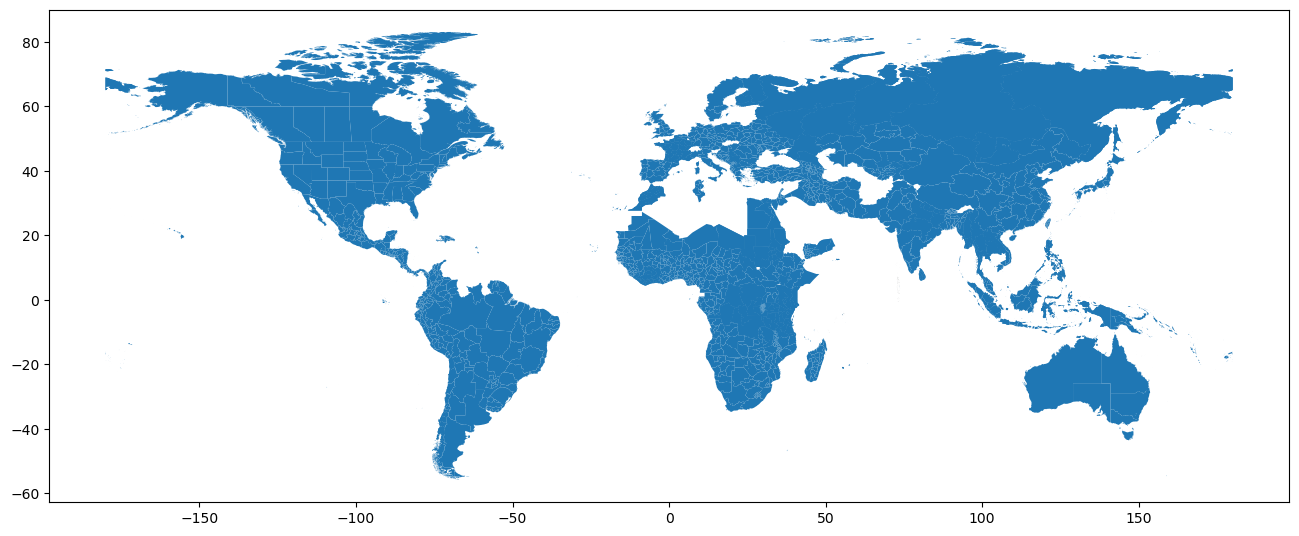

In [4]:
ax = gdf.plot()

ax.get_figure().set_size_inches(16,8)


## handle the more complex inequality data

In [67]:
output_keys = ['year','mean2017','poor215','poor365','poor685','prosgap2017','gini','theil']

In [68]:
refoo = df.set_index('geo_code').sort_index()

In [76]:
for group, data in refoo.groupby('code'):
    output_data = {}
    data = data.reset_index()
    for subgroup, subdata in data.groupby('geo_code'):
        subdata = subdata.set_index('data_group')
        subdata = subdata.sort_values('year')
        result = subdata[output_keys].groupby(subdata.index).agg(list)
        output_data[subgroup] = result.to_json(orient='index')
    with open(f'../app/public/data/spid-inequality/{group}_spid_inequality.json','w') as handle:
        json.dump(output_data,handle)

## Output the geometry

In [28]:
gsap_2021_gdf = gpd.read_file('../data/GSAP_geom/GSAP_AM24_2021.shp')
gdf = gpd.read_file('../data/SPID_geom/am24_subnat_em.shp')

In [31]:
for group, data in gdf.groupby('code'):
    base = '../app/public/data/sub-national-geometry/'
    data = data[['geo_code','geo_name','geometry']].copy()
    data['geometry'] = data['geometry'].simplify(tolerance=0.001, preserve_topology=True)
    data.to_file(os.path.join(base,f"{group}_spid_geometry.geojson"),driver='GeoJSON')